In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importamos y configuramos librerias

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
from dateutil.tz import gettz

In [185]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Diccionario para interpretar PDT
tzinfos = {
    "PDT": gettz("America/Los_Angeles"),
    "PST": gettz("America/Los_Angeles")
}

In [186]:
ROOT_PATH = '/content/drive/Othercomputers/Mi MacBook Pro/Google Drive/tp3'

In [187]:
training_csv = '/trainingandtestdata/training.1600000.processed.noemoticon.csv'

In [188]:
df = pd.read_csv(ROOT_PATH + training_csv, encoding='latin1', names=['Polarity', 'ID', 'Date', 'Query', 'User', 'Text'])

In [189]:
df

In [190]:
df.shape

(1600000, 6)

Validamos que no existan valores nulos

In [191]:
df.isna().sum()

,0
Polarity,0
ID,0
Date,0
Query,0
User,0
Text,0


Revisamos que no exista una cantidad de usuarios repetidos que pueda sesgar el modelo

In [192]:
df.User.nunique()

659775

*En este caso existe una diferencia importante de usuarios únicos, lo que puede aportar información importante al modelo*.


Graficamos la relación de polaridad y temporalidad.

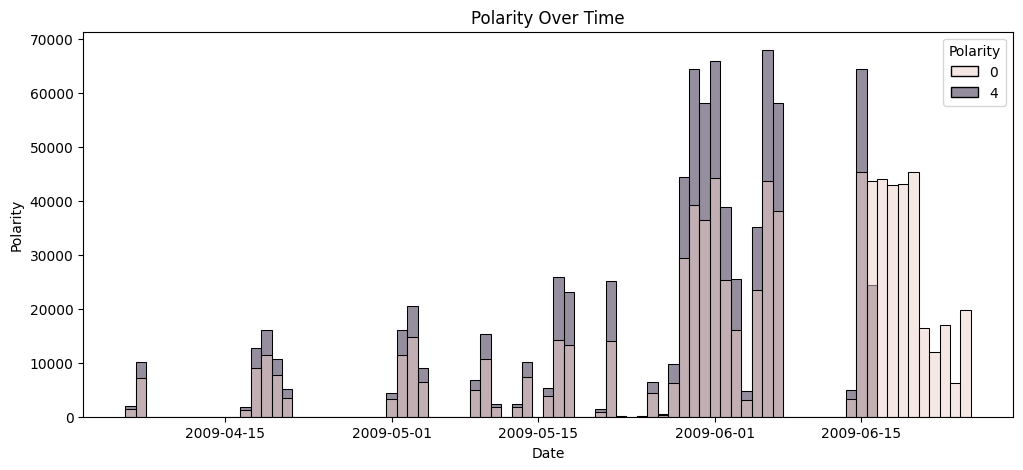

In [193]:
df_copy = df.copy()

df_copy['DateOnly'] = df_copy.Date.apply(lambda x: parser.parse(x, tzinfos=tzinfos).date())

plt.figure(figsize=(12,5))
sns.histplot(data=df_copy, x='DateOnly', hue='Polarity')
plt.xlabel("Date")
plt.ylabel("Polarity")
plt.title("Polarity Over Time")
plt.show()


En la gráfica se puede ver una mayor cantidad de tweets para los días 01 y 15 de Junio, lo que puede darse por un trending topic.

Descartamos el dato fecha para no dar un sesgo por temporalidad.

Definimos una función para agrupar por momentos del día.

In [194]:
def TimeOfDay(fecha_str):
    dt = parser.parse(fecha_str, tzinfos=tzinfos)  # reconoce PDT automáticamente
    hora = dt.hour

    if 5 <= hora < 12:
        return "morning"
    elif 12 <= hora < 14:
        return "noon"
    elif 14 <= hora < 19:
        return "after noon"
    elif 19 <= hora < 24:
        return "night"
    else:
        return "early morning"

In [195]:
df.loc[:, "TimeOfDay"] = df.Date.apply(TimeOfDay)
df

In [196]:
df.groupby('TimeOfDay').Polarity.value_counts(normalize=True) * 100

TimeOfDay      Polarity
after noon     0           55.687199
               4           44.312801
early morning  4           57.260365
               0           42.739635
morning        0           51.076335
               4           48.923665
night          0           50.696176
               4           49.303824
noon           0           54.833139
               4           45.166861
Name: proportion, dtype: float64

Observamos que hay una distribución equilibrada en los diferentes momentos del día, por lo cual descartamos este dato al no considerarse relevante.

Revisamos la distribución de las polaridades

In [197]:
df.Polarity.value_counts(normalize=True) * 100

,proportion
Polarity,
0,50.0
4,50.0


Finalmente se decide trabajar únicamente con el texto del tweet, para gene.

In [198]:
df = df[['Text', 'Polarity']]

In [199]:
df.to_csv(ROOT_PATH + '/trainingandtestdata/big_tweets_cleaned.csv', index=False)